## Filter out most rated items/users from the Netflix data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

###Import Kaggle data to dataframe

In [ ]:
def import_data_from_kaggle():
  ### Import data from Kaggle (kaggle.json downloaded from kaggle and uploaded to google drive folder)
  ! pip install kaggle
  from google.colab import drive
  drive.mount('/content/drive')

  ! mkdir ~/.kaggle
  !cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle/kaggle.json
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download -d netflix-inc/netflix-prize-data
  ! unzip netflix-prize-data.zip
  data = open('data.csv', mode='w')
  row = list()
  files = ['/content/combined_data_1.txt',
         '/content/combined_data_2.txt',
         '/content/combined_data_3.txt',
         '/content/combined_data_4.txt']
  for file in files:
    print("Reading ratings from {}\n".format(file))
    with open(file) as f:
      for line in f:
        line = line.strip()
        if line.endswith(':'):
          # All below are ratings for this movie, until another movie appears.
          movie_id = line.replace(':', '')
        else:
          row = [x for x in line.split(',')]
          row.insert(0, movie_id)
          data.write(','.join(row))
          data.write('\n')
  data.close()

In [ ]:
def create_full_df():
  ### Complete dataframe with all ratings (remove date column)
  df_full = pd.read_csv('data.csv', sep=',',
      names=['item', 'user', 'rating', 'date'])
  return df_full.drop(['date'], axis=1)

In [ ]:
def import_data_to_df():
  import_data_from_kaggle()
  df = create_full_df()
  return df

In [ ]:
### Run this cell only once!
df_full = import_data_to_df()

Mounted at /content/drive
100% 680M/683M [00:08<00:00, 204MB/s]
100% 683M/683M [00:08<00:00, 88.7MB/s]
Archive:  netflix-prize-data.zip
  inflating: README                  
  inflating: combined_data_1.txt     
  inflating: combined_data_2.txt     
  inflating: combined_data_3.txt     
  inflating: combined_data_4.txt     
  inflating: movie_titles.csv        
  inflating: probe.txt               
  inflating: qualifying.txt          
Reading ratings from /content/combined_data_1.txt

Reading ratings from /content/combined_data_2.txt

Reading ratings from /content/combined_data_3.txt

Reading ratings from /content/combined_data_4.txt



### Filter out most rated users/items

In [ ]:
def get_dense_df(df_full, u, i):
  ### Produce a dense matrix by taking the u,m most rated users and items
  users = df_full['user'].value_counts()[:u].index.tolist()
  items = df_full['item'].value_counts()[:i].index.tolist()
  df = df_full[df_full['user'].isin(users) & df_full['item'].isin(items)]
  replace_idxes(df)
  return df

In [ ]:
def print_df_stats(df):
  n_u = df.user.nunique()
  n_i = df.item.nunique()
  n_datapts = df.shape[0]
  sparsity = n_datapts/(n_u*n_i)
  print('Sparsity: ' + str(sparsity))
  print('Number of datapoints: ' + str(n_datapts))
  print('Number of unique users and movies: ' + str(n_u) + ', ' + str(n_i) + '\n')

In [ ]:
def save_df(df, name):
  df = df.reset_index(drop=True)
  df.to_csv(name)

In [ ]:
def make_idx_dict(idx_list):
  idx_dict = {}
  i = 0
  for u in idx_list:
    if u not in idx_dict:
      idx_dict[u] = i
      i += 1
  return idx_dict

In [ ]:
def list_and_dict_from_df_col(df, col_name):
  col_list = df[col_name].tolist()
  col_dict = make_idx_dict(col_list)
  return col_list, col_dict

In [ ]:
def replace_idxes(df):

  user_list, user_dict = list_and_dict_from_df_col(df, 'user')
  item_list, item_dict = list_and_dict_from_df_col(df, 'item')

  new_users = [user_dict[user] for user in user_list]
  new_items = [item_dict[item] for item in item_list]

  df['user'] = df['user'].map(user_dict).fillna(df['user'])
  df['item'] = df['item'].map(item_dict).fillna(df['item'])

In [ ]:
def get_df(df_full, usize, isize):
  df = get_dense_df(df_full, usize, isize)
  print_df_stats(df)
  name = f"df_size_{usize}_{isize}.csv"
  save_df(df, name)
  return df

size = 2000
df = get_df(df_full, size, size)

Sparsity: 0.59711575
Number of datapoints: 2388463
Number of unique users and movies: 2000, 2000



### Data analysis

In [ ]:
dp = len(df_full)
nu = df_full.user.nunique()
ni = df_full.item.nunique()

print(dp, nu, ni)

100480507 480189 17770


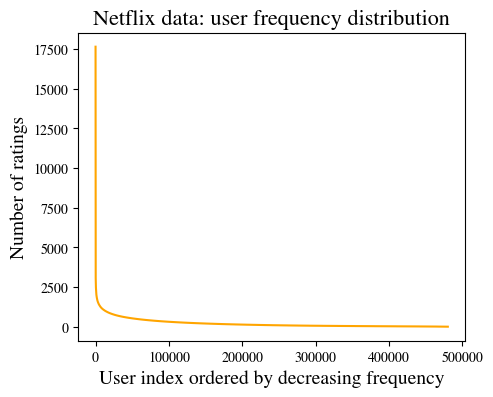

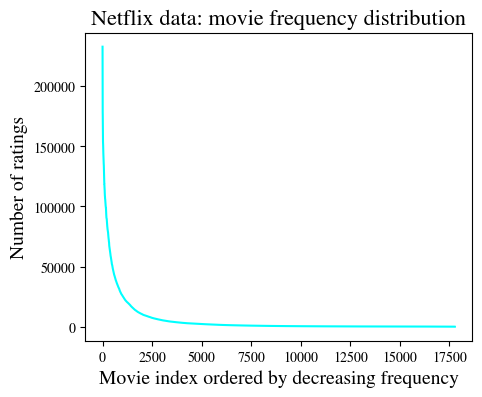

In [ ]:
# New dataframes with counts of items and users
df_u = df_full.groupby(['user'])['item'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
df_i = df_full.groupby(['item'])['user'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
df_u = df_u.reset_index(drop=True)
df_i = df_i.reset_index(drop=True)
n_u = df_u.Count
n_i = df_i.Count

plt.plot(n_u, color = 'orange')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.xlabel('User index ordered by decreasing frequency', fontsize = 14)
plt.ylabel('Number of ratings', fontsize = 14)
plt.title('Netflix data: user frequency distribution', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(5,4)
plt.savefig('u_freq_full.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.plot(n_i, color = 'cyan')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.xlabel('Movie index ordered by decreasing frequency', fontsize = 14)
plt.ylabel('Number of ratings', fontsize = 14)
plt.title('Netflix data: movie frequency distribution', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(5,4)
plt.savefig('m_freq_full.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


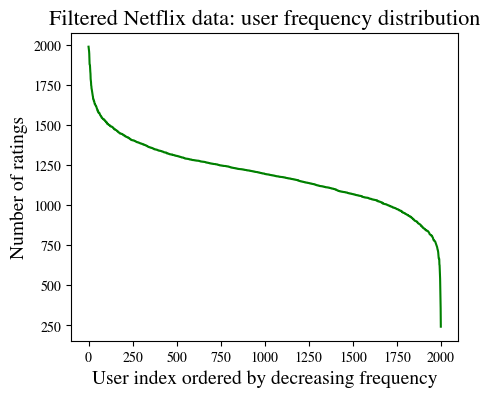

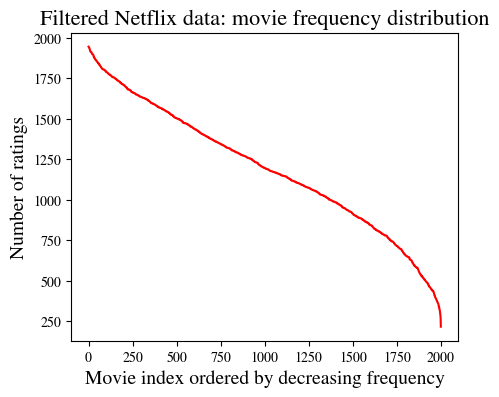

In [ ]:
# New dataframes with counts of items and users

df_u = df.groupby(['user'])['item'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
df_i = df.groupby(['item'])['user'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
df_u = df_u.reset_index(drop=True)
df_i = df_i.reset_index(drop=True)
n_u = df_u.Count
n_i = df_i.Count

plt.plot(n_u, color = 'green')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.xlabel('User index ordered by decreasing frequency', fontsize = 14)
plt.ylabel('Number of ratings', fontsize = 14)
plt.title('Filtered Netflix data: user frequency distribution', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(5,4)
plt.savefig('u_freq_filtered.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.plot(n_i, color = 'red')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.xlabel('Movie index ordered by decreasing frequency', fontsize = 14)
plt.ylabel('Number of ratings', fontsize = 14)
plt.title('Filtered Netflix data: movie frequency distribution', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(5,4)
plt.savefig('m_freq_filtered.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
